In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, shutil, bz2, warnings
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
from numpy.random import Generator, PCG64
rng_pg = Generator(PCG64())
from scipy.optimize import newton, minimize, fsolve
from scipy.optimize import nnls
import statsmodels.api as sm
import statsmodels.formula.api as smf


### Plotting imports ###
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("notebook")
%matplotlib inline

from wand.image import Image as WImage

In [2]:
# Navigate back to NBdir in case of re-running a code block:
if not 'NBdir' in globals():
    NBdir = os.getcwd()
print('Notebook is in: {}'.format(NBdir))
os.chdir(NBdir)  # If you changed the current working dir, this will take you back to the notebook dir.

# Define the path to the repo folder.
# Change if necessary.
homedir = '/'.join(NBdir.split('/')[0:-2])
print('Repo is in: {}'.format(homedir))
sys.path.insert(1, homedir)
from src.stats_collection import STATS_collection
from src.plotting import TRNA_plot
from src.curve_fitting import loss_func_c1, loss_func_l1, loss_func_l2, hl_bsl_fit, lin_fit_off, obj_lin_fit_off, bootstrap_hl, bootstrap_hl_fast

# These are default folder names for data and raw fastq files
# relative to the folder in which this notebook is in:
data_dir = 'data'
stats_dir = 'stats_collection'
plotting_dir = 'plotting'

Notebook is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq/projects/charge_titration
Repo is in: /Users/krdav/Google Drive/MCB/Sullivan_lab/tRNA-charge-seq


# Charge titration to validate tRNA-charge sequencing approach
In this notebook I will process and analyze the samples generated to validate the tRNA-charge sequencing approach.
The summary of the finding of this analysis is:
* tRNA oxidation/cleavage goes to completion, thus the initial step of charge discrimination is quantitative 
* tRNA abundance is affected by the oxidation/cleavage reactions but relative abundance is comparable between samples that have undergone the same treatment
* tRNA charge can be determined quantitatively


### Sample description
To generate samples with known tRNA acetylation leves a mixture of intact and deacetylated tRNA was made.
The intact tRNA was isolated from a cell culture, split in two and one part deacylated before mixing them together at different ratios.
A titration was made to establish a linear range of tRNA charging quantification.
The titration spans 8 different ratios: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100 of percentage charge/uncharge.

If there is a adapter ligation bias, this should reveal itself as a deviation from linearity between predicted and measured tRNA charge.
Because the substrate is a complex mix of tRNAs isolated from a cell culture, it will be possible to reveal ligation bias on the transcript level.



#### Protocol for preparing the tRNA titration
1. Isolate whole cell RNA from adherent cells using Trizol. Place dish on ice, thoroughly aspirate media, then add enough Trizol to cover the cells. From this point onwards, keep the RNA cold and work fast to retain tRNA acylation. Scrape cells and move to tube, add chloroform, vortex 5 min and spin. Precipitate RNA with IPA, spin and wash the pellet twice in acetate buffered 80% IPA (pH=4.5), then do a final wash in 100% IPA and dry RNA pellet. Dry RNA pellets can be stored at -80C for months without detectable loss of acetylation.
2. Prepare deacetylated tRNA by taking a tube with whole cell RNA, reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL. Add 50 uL 1M lysine (pH=8) per 10 uL RNA and incubate 4 h at 45C. After incubation, lower the pH by adding 10 uL 11 M sodium acetate per 10 uL RNA, then precipitate, wash and reconstitute with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
3. Prepare intact tRNA by taking a tube with whole cell RNA and reconstituting it with 100 mM sodium acetate, pH=4.5, measure the RNA concentration and adjust it to 1 ug/uL.
4. Make a titration of the following percentages of intact/deacylated RNA: 100/0, 85/15, 70/30, 55/45, 40/60, 25/75, 10/90, 0/100
5. Perform periodate oxidation, including adding E.coli control, and subsequent steps following the tRNA-charge-seq protocol with the appropriate scaling
6. At the adapter ligation step, use multiple adapters for each titration ratio to get barcode level replicates


### Read and filter input data
A sample list is provided to filter the samples for further use and add relevant sample level information.
The data is read from a .csv file with aggregated sample statistics.
This .csv file was generated using the standard process described in the tRNA-seq-charge repo and is the result of using the `STATS_collection` class.
Below the `TRNA_plot` class is used to extract the relevant tRNA charge information at transcript level.

In [3]:
sample_list_fnam = 'sample_list.xlsx'
sample_df = pd.read_excel('{}/{}'.format(NBdir, sample_list_fnam))
# Isolate the titration samples:
mask = (sample_df['plot_group'] == 'Charge-titration') & (sample_df['sample_name'] != '0p_90m') & (sample_df['sample_name'] != '100p')
sample_df = sample_df[mask].reset_index(drop=True).copy()

# Make a dictionary with paths used for data processing:
dir_dict = dict(NBdir = NBdir,
                data_dir = data_dir,
                stats_dir = stats_dir,
                plotting_dir = plotting_dir)

# Get charge dataframe for aggregated stats:
plot_obj = TRNA_plot(dir_dict, sample_df=sample_df, \
                     stats_fnam='ALL_stats_aggregate.csv', \
                     overwrite_dir=False)
plot_obj.get_charge_df()

Folder exists and overwrite set to false... Doing nothing.


In [4]:
# Add E.coli control RPM to sample level information:
ectr = plot_obj.charge_filt['tr'][plot_obj.charge_filt['tr']['Ecoli_ctr']].copy()
sample_df = ectr.loc[:, ['sample_name_unique', 'RPM']].merge(sample_df, on='sample_name_unique')
sample_df = sample_df.rename(columns={'RPM': 'RPM_Ectr'}, errors='ignore')

# Select the titration samples and add sample information:
charge_df = sample_df.loc[:, ['sample_name_unique', 'hue_value', 'hue_order', 'RPM_Ectr']].merge(plot_obj.charge_filt['tr'], on='sample_name_unique')

# Convert percent charged to an integer value:
frac_list = list()
for sn in charge_df['sample_name']:
    try:
        frac_list.append(int(sn[0:3]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:2]))
        continue
    except:
        pass
    try:
        frac_list.append(int(sn[0:1]))
        continue
    except:
        raise Exception('???')
charge_df['percent_charged'] = frac_list

In [5]:
# Enforce minimum read count:
min_count = 1000
# For each tRNA annotation, find samples
# that have above the minimum count:
tann2snu = dict()
for snu, tann, ectr, cnt in zip(charge_df['sample_name_unique'], \
                               charge_df['tRNA_annotation'], \
                               charge_df['Ecoli_ctr'], \
                               charge_df['count']):
    if ectr or cnt < min_count:
        continue
    
    if tann in tann2snu:
        tann2snu[tann].add(snu)
    else:
        tann2snu[tann] = set()
        tann2snu[tann].add(snu)

# Filter tRNA annotation based on
# all samples having above the minimum count:
all_snu = set(charge_df['sample_name_unique'])
tann_sele = set()
for tann in tann2snu:
    if tann2snu[tann] == all_snu:
        tann_sele.add(tann)
mask = charge_df['tRNA_annotation'].isin(tann_sele)
titr_df = charge_df[mask].copy()
titr_df['RPM_norm'] = titr_df['RPM'] / titr_df['RPM_Ectr']

### Check data integrity
Ploting the "charge" of the E.coli control tRNA in each sample.

The E.coli control was added to check that the NaIO4 oxidation and lysine cleavage reaction goes to completion and therefore should appear as 0% charged (i.e. all CC, no CCA); however, typically, a smaller percentage remains intact and thus will appear as charged.
This, is also apparent below where most samples have a measured charge for the E.coli control samples of ~1% and no samples are above 2%.
Whether this small residual "charge" reflects the incompletion of the NaIO4 oxidation and lysine cleavage reaction or is a sequencing artifact is unknown, but we take it that the levels are so low that for most pratical purposes, including this analysis, the reaction can be assumed complete.

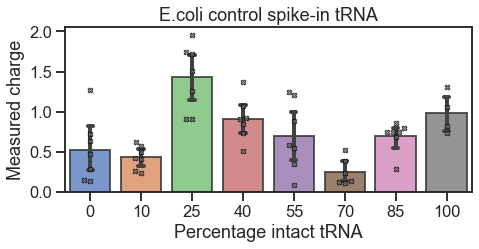

In [6]:
# Select E.coli controls samples:
ectr_mask = charge_df['Ecoli_ctr']
fig, ax1 = plt.subplots(1, 1, figsize=(7, 3.8))

g1 = sns.barplot(ax=ax1, data=charge_df[ectr_mask], x='percent_charged', y='charge', \
                 capsize=0.1, edgecolor=".2", linewidth=2, alpha=0.8)
g1 = sns.swarmplot(ax=ax1, data=charge_df[ectr_mask], x='percent_charged', y='charge', \
                   color='grey', alpha=0.8, edgecolor='black', linewidth=0.8, \
                   size=5, marker="X")
g1.set(xlabel='Percentage intact tRNA', ylabel='Measured charge')
g1.set_title('E.coli control spike-in tRNA')
fig.tight_layout()
fig.savefig('data/plotting/ecoli-control_charge.pdf', bbox_inches='tight')

### Predicted vs. measured tRNA charge
As described in the above protocol, the RNA concentrations were measured and adjusted before mixing a known ratio of intact and deacylated RNA; however, it is not given that the RNA concentration is 100% accurate and it is also not known whether some tRNAs are preferentially accumulating as a result of the deacylation step.
We will remain agnostic to both of these possibilities by assuming that the concentration of each tRNA transcript is unknown in the deacylated sample.

Let $A$ represent intact RNA and $B$ represent deacylated RNA.
Assume the concentration of a tRNA transcript $i$ in the intact RNA as $1$:
$$
C^A_i = 1
$$
While letting the concentration of the same tRNA transcript in the deacylated RNA be unknown:
$$
C^B_i = F_i <=> F_i = \frac{C^B_i}{C^A_i}
$$

Define $T^A_i$ as the average measured charge of the intact tRNA of a transcript $i$
$$
T^A_i = \text{Avg charge}(A_i)
$$
And similarily for deacylated RNA:
$$
T^B_i = \text{Avg charge}(B_i)
$$

Now, the predicted charge of a mixture of $A$ and $B$ can be defined using $p$ to describe the percentage of $A$ in the mixture:
$$
T^{AB}_i(p) = \frac{p T^A_i + (100-p) T^B_i F_i}{p + (100-p) F_i}
$$

In the above, only $F_i$ is unknown.
The titration was made with 8 different mixing ratios, two of which are used to fix the upper/lower bounds of the predicted charge, thus leaving 6 mixing ratios, each with several barcode replicates, to fit $F_i$ such that the squared difference between predicted and measured charge is minimized.

Alternatively, instead of fitting $F_i$ using the charge data it can be calculated using the abundance data.
tRNA abundance is measured by read counts which are relative to the sequencing depth and therefore normalized as reads per million (RPM).
The RPM value for each transcript is then normalized to the RPM value of the E.coli spike-in control to get a pseudo-quantitative metric:
$$
R^A_i = \frac{\text{RPM}^A_i}{\text{RPM}^A_{ecoli}}
$$

$F_i$ can then be calculated as:
$$
F_i = \frac{R^B_i}{R^A_i}
$$


Below, both approaches are implemented and compared.

In [7]:
# Function to infer and calculate the concentration of deacylated
# compared to intact RNA (correction factor)
# including plotting of the results.
def infer_FB(df, tRNA_name, BFGS_loss_func=loss_func_l2, plot_return=True, plot_fh=None):
    # Extract information for the fit:
    x = df['percent_charged'].values # "p" above
    y = df['charge'].values          # The measured charge
    A_charge = y[x==100].mean()      # "TA_i" above
    B_charge = y[x==0].mean()        # "TB_i" above
    
    # Input realistic bounds (4x either direction)
    # and use no difference as initial guess:
    bnds = ((0.25, 4), )
    guess = (1, )
    # Do the minimization with BFGS:
    def fun_F(p): return(obj_F_fit(BFGS_loss_func, x, y, A_charge, B_charge, p))
    p_fun_FB = minimize(fun_F, guess, method='L-BFGS-B', bounds=bnds)
    FB_inferred = p_fun_FB.x[0]
    # Calculate the signed prediction error
    # this would be percentage point deviation:
    x_trans = x_trans_fun(x, A_charge, B_charge, FB_inferred)
    pred_err = y - x_trans
    df['pred_err'] = pred_err
    
    # "Calculate" the correction factor
    # using the e.coli spike-in normalized RPM values:
    ms = (x < 100) # drop 100p samples b/c e.coli control was added at different quantity
    y2 = df['RPM_norm'].values
    # Make a linear fit to use all data to better
    # predict normalized RPM:
    A = np.vstack([x[ms], np.ones(len(x[ms]))]).T
    slope, intersection = np.linalg.lstsq(A, y2[ms], rcond=None)[0]
    # Calculate the correction factor:
    rpm0_pred = intersection
    rpm100_pred = intersection + 100*slope
    FB_calculated = rpm0_pred/rpm100_pred
    

    ### Plotting ###
    fig = plt.figure(figsize=(16, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1.3, 1])
    
    # Predicted vs. measured using "inferred" correction factor:
    ax1 = fig.add_subplot(gs[0, 0])
    g1 = sns.scatterplot(ax=ax1, x=x_trans, y=y, zorder=10, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g1.set_title('Factor inferred {:.2f}'.format(FB_inferred))
    g1.set(xlabel='Predicted charge', ylabel='Measured charge')
    ax1.plot(x, x, c='r', zorder=1)
    
    # Prediction error broken down by barcode:
    with sns.axes_style("whitegrid"):
        ax2 = fig.add_subplot(gs[0, 1])
        bc_order = sorted(set(df['barcode']))
        g2 = sns.boxplot(ax=ax2, data=df, x='barcode', y='pred_err', boxprops=dict(alpha=0.8), \
                         order=bc_order, fliersize=False, zorder=10)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sns.swarmplot(ax=ax2, data=df, x='barcode', y='pred_err', size=4, \
                      order=bc_order, color='white', alpha=0.8, edgecolor='black', \
                      linewidth=0.8, marker="X", zorder=11)
    g2.set_title('Barcode bias')
    g2.set(xlabel='Barcode', ylabel='Error (measured - predicted)')

    # Normalized RPM data and linear fit to
    # generate the "calculated" correction factor:
    ax3 = fig.add_subplot(gs[0, 2])
    g3 = sns.scatterplot(ax=ax3, x=x[ms], y=y2[ms], zorder=11, alpha=0.5, \
                         edgecolor='black', linewidth=0.7)
    g3.set_title('Factor calculated {:.2f}'.format(FB_calculated))
    g3.set(xlabel='Percent deacylated tRNA', ylabel='RPM (norm. to spike-in)')
    y2_pred = intersection + slope*x
    ax3.plot(x, y2_pred, c='r', zorder=1)
    
    fig.suptitle('{}'.format(tRNA_name), size=15);
    fig.tight_layout()

    # Save plots:
    if not plot_fh is None:
        plot_fh.savefig(fig, bbox_inches='tight')
    else:
        fig.savefig('data/plotting/{}.pdf'.format(tRNA_name), bbox_inches='tight')
    if plot_return is False:
        plt.close(fig)
    
    return((FB_inferred, FB_calculated), pred_err)


# Objective function for fitting the F_i variable:
def obj_F_fit(loss_func, x, y, A_charge, B_charge, p):
    F = p[0]
    x_trans = x_trans_fun(x, A_charge, B_charge, F)

    loss = sum(loss_func(y, x_trans))
    return(loss)

# Function to calculate the predicted charge:
def x_trans_fun(x, A_charge, B_charge, F):
    return((x*A_charge + (100-x)*F*B_charge) / (x + (100-x)*F))


In [8]:
# Run analysis on titration data
# one tRNA transcript at the time:
FB_res = list()
bc_err = {bc: [] for bc in set(titr_df['barcode'])}
anno_list = list(tann_sele)
with PdfPages('data/plotting/titration-fit.pdf') as pp:
    for tann in anno_list:
        # Extract dataframe with single tRNA annotation:
        sample_mask = (titr_df['tRNA_annotation'] == tann)
        titr_spl = titr_df[sample_mask].copy()
        tann_short = titr_spl['tRNA_anno_short'].drop_duplicates().values[0]

        # Perform correction factor inference and plot:
        FB_tup, pred_err = infer_FB(titr_spl, tann_short, plot_fh=pp, plot_return=False)
        FB_res.append(FB_tup)
        # Save the prediction error for each barcode:
        for bc, pe in zip(titr_spl['barcode'], pred_err):
            bc_err[bc].append(pe)
        
# Correction factor "inferred" and "calculated" to dataframe:
FB_df = pd.DataFrame(FB_res).rename(columns={0: 'Inferred', 1: 'Calculated'})
FB_df['tRNA_annotation'] = anno_list
FB_df = FB_df.merge(titr_df.loc[:, ['tRNA_annotation', 'tRNA_anno_short', 'tRNA_annotation_len', \
                                    'codon', 'anticodon', 'AA_codon', 'amino_acid', 'AA_letter', \
                                    'mito_codon', 'Ecoli_ctr']], \
                    on='tRNA_annotation').drop_duplicates().reset_index(drop=True)

# Barcode error to dataframe:
bc_keys = list(bc_err.keys())
bc_err_df = pd.DataFrame({
    'barcode': np.repeat(bc_keys, [len(bc_err[k]) for k in bc_keys]),
    'pred_err': [err_i for k in bc_keys for err_i in bc_err[k]]
})

We can check the results by looking at the fit for a random trancript.
The left scatterplot shows the predicted vs. measured charge using the inferred correction factor to make the prediction.
The red line shows a perfect 1:1 fit.
The middle boxplot shows the prediction error of the left plot broken down by barcode.
The right scatterplot shows the E.coli spike-in normalized RPM values as a function of the percentage of deacylated tRNA in the mixture.
The linear fit used to calculated the correction factor is shown as a red line.

The plot in the right shows that the normalized RPM values are quite variable, probably because this number is affected by the variance of both the RPM value of the transcript and the RPM value of the E.coli spike-in.
It is clear from the left plot that the charge titration is highly linear and close to the predicted charge values.
This means that tRNA charge can be quantified reliably for this tRNA transcript.

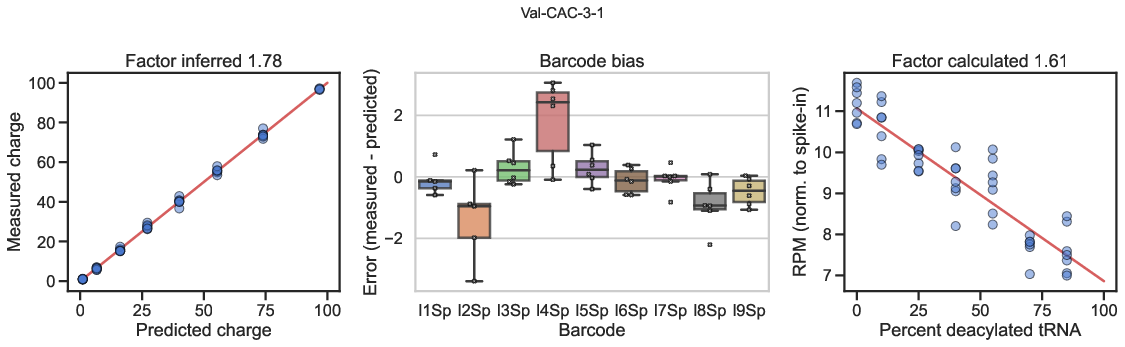

In [9]:
random_image = np.random.randint(len(anno_list))
img = WImage(filename='data/plotting/titration-fit.pdf[{}]'.format(random_image))
img

Looking at the "inferred" vs "calculated" abundance correction factor there is a clear correlation but it deviates from the expected 1:1 proportionality marked by a red line.
The reason for this deviation is unknown.

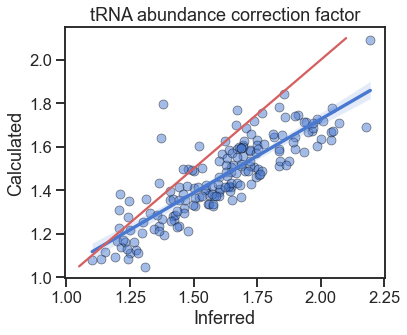

In [10]:
# Plot inferred vs. calculated correction factor:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 5))

g1 = sns.regplot(ax=ax1, data=FB_df, x='Inferred', y='Calculated', \
                 scatter_kws=dict(alpha=0.5, edgecolor='black', linewidth=0.7))
g1.set(xlabel='Inferred', ylabel='Calculated')
g1.set_title('tRNA abundance correction factor')
ax1.plot([1.05, 2.1], [1.05, 2.1], c='r')
fig.tight_layout()
fig.savefig('data/plotting/correction-factor.pdf', bbox_inches='tight')

The barcode bias summarized over all the tRNA annotations can give us a clue as to whether any barcode is problematic.
In this case, the boxplot shows that barcode 4 (l4Sp) is slightly biased towards higher measured charge which could be because the adapter with this barcode has a slight ligation preference towards CCA as opposed to CC.
All the other barcodes have a tight error distribution around or close to zero and thus not showing any ligation bias.

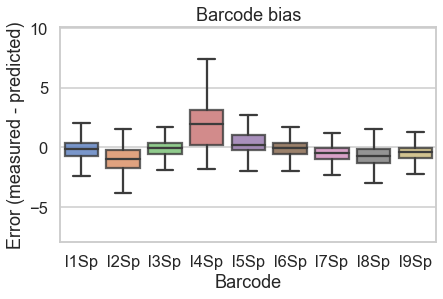

In [11]:
# Plot the prediction error for all the tRNA annotations
# broken down by barcode:
bc_order = sorted(set(bc_err_df['barcode']))
with sns.axes_style("whitegrid"):
    fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 4.5))
    g1 = sns.boxplot(ax=ax1, data=bc_err_df, x='barcode', y='pred_err', \
                     boxprops=dict(alpha=0.8), order=bc_order, fliersize=False)

g1.set(xlabel='Barcode', ylabel='Error (measured - predicted)')
g1.set_title('Barcode bias')
fig.tight_layout()
fig.savefig('data/plotting/barcode_prediction-error.pdf', bbox_inches='tight')

# And dump the data summary as an Excel file:
bc_err_df.pivot(columns='barcode').describe().to_csv('barcode-bias_summary.csv')

### Investigating the variables influencing tRNA abundance after deacylation treatment
The correction factors inferred above range between 1.1 and 2.2, thus suggesting that during the deacetylation process some transcripts were depleted and some enriched.
It would be useful to know what caused this depletion/enrichment.

In the following section, I will apply a simple linear regression model to test if the magnitude of the correction factor can be predicted from the amino acid identity, tRNA length and whether it is a mito or cyto tRNA.

In [12]:
FB_df.head(3)

,Inferred,Calculated,tRNA_annotation,tRNA_anno_short,tRNA_annotation_len,codon,anticodon,AA_codon,amino_acid,AA_letter,mito_codon,Ecoli_ctr
0,1.364651,1.237707,Homo_sapiens_tRNA-Ala-TGC-5-1,Ala-TGC-5-1,75,GCA,TGC,Ala-GCA,Ala,A,False,False
1,1.694585,1.607239,Homo_sapiens_tRNA-Gly-GCC-1-1,Gly-GCC-1-1,74,GGC,GCC,Gly-GGC,Gly,G,False,False
2,1.941384,1.712923,Homo_sapiens_tRNA-Leu-CAA-4-1,Leu-CAA-4-1,87,UUG,CAA,Leu-UUG,Leu,L,False,False


In [13]:
# Run OLS:
results = smf.ols('Inferred ~ tRNA_annotation_len + amino_acid + mito_codon', data=FB_df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     10.21
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           9.74e-21
Time:                        21:23:47   Log-Likelihood:                 89.570
No. Observations:                 175   AIC:                            -131.1
Df Residuals:                     151   BIC:                            -55.18
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.8382    

The regression shows a bad fit.
Most independent variables are not significantly improving the model $(P>|t|)$ and the R-squared is low considering the large amount of variables.
Nevertheless, select the signification variables, refit the model and plot the predictions vs. true values:

In [19]:
endog = pd.DataFrame(results.model.endog, columns=[results.model.endog_names])
exog = pd.DataFrame(results.model.exog, columns=results.model.exog_names)
cols_sele = ['Intercept', 'amino_acid[T.Arg]', 'amino_acid[T.Asn]', 'amino_acid[T.Cys]', \
'amino_acid[T.Ile]', 'amino_acid[T.Leu]', 'amino_acid[T.Pro]', 'amino_acid[T.Thr]', \
'amino_acid[T.Trp]', 'amino_acid[T.Val]', 'amino_acid[T.iMet]']
results = sm.OLS(endog, exog=exog.loc[:, cols_sele]).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               Inferred   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     20.16
Date:                Tue, 07 Mar 2023   Prob (F-statistic):           5.77e-24
Time:                        21:26:35   Log-Likelihood:                 77.627
No. Observations:                 175   AIC:                            -133.3
Df Residuals:                     164   BIC:                            -98.44
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.5198      0

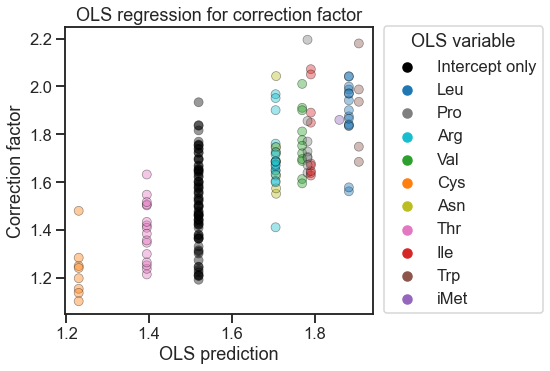

In [21]:
# Plot the regression results:
FB_df['Inferred_fitted'] = results.fittedvalues
aa_sele = {'Arg', 'Asn', 'Cys', 'Ile', 'Leu', 'Pro', 'Thr', 'Trp', 'Val', 'iMet'}
AArgb_dict = dict()
cmap_b = mpl.colormaps['tab10']
for aai, aa in enumerate(aa_sele):
    AArgb_dict[aa] = cmap_b(aai)

color_list = list()
aa_sele_list = list()
for aa in FB_df['amino_acid']:
    if aa in aa_sele:
        color_list.append(AArgb_dict[aa])
        aa_sele_list.append(aa)
    else:
        color_list.append((0,0,0,1))
        aa_sele_list.append('Intercept only')

FB_df['Variable'] = aa_sele_list
sns_palette = {aa:col for aa, col in zip(aa_sele_list, color_list)}

fig, ax1 = plt.subplots(1, 1, figsize=(8, 5.5))
g1 = sns.scatterplot(ax=ax1, data=FB_df, x='Inferred_fitted', y='Inferred', \
                     alpha=0.4, hue='Variable', \
                     edgecolor='black', linewidth=0.7, \
                     palette=sns_palette)
sns.move_legend(g1, "upper left", bbox_to_anchor=(1.01, 1.03), ncol=1, title='OLS variable')
g1.set(xlabel='OLS prediction', ylabel='Correction factor')
g1.set_title('OLS regression for correction factor')
fig.tight_layout()
fig.savefig('data/plotting/correction-factor_OLS-prediction.pdf', bbox_inches='tight')

The plot makes it clear how bad the prediction is; however, it does show that tRNAs with Cys/Thr codons have mean correction factors lower than average i.e. depletion and conversely that the other amino acid variables, and especially Leu/Trp, have higher correction factors than average i.e. enrichment.

We could employ better methods for variable selection such as rigde and LASSO regression; however, these just remove all the variables because of their low influence (did try though).
In the end, it remains unknown what makes the acylated and deacylated tRNA have such different tRNA content at the transcript level. But luckily, there is enough dilutions on the titration curve to infer an abundancen correction factor for each transcript, solving the problem and enabling the finding of the linear range of charge measurements.
Such correction factor can of course not be calculated for single samples and therefore the observation that the deacylation procedure affected the apparent tRNA transcript abundance shows that to compare relative expression levels between samples one must carefully apply the same conditions to all samples and use technical replicates to minimize false positives.